In [1]:
import numpy as np
import scipy
import pandas as pd
import math
import random
import sklearn
from nltk.corpus import stopwords
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Loading data

## Shared_articles.csv
Contains information (like date (timestamp), the original url, title, etc) about the **articles shared** in the platform and  information about the **user** who shared the article (**author**)

In [2]:
articles_df = pd.read_csv('./data/deskdrop/shared_articles.csv')
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
0,1459192779,CONTENT REMOVED,-6451309518266745024,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en


For the sake of simplicity, we only consider here the **CONTENT SHARED** for now

In [3]:
articles_df = articles_df[articles_df["eventType"] == "CONTENT SHARED"]
articles_df.head()

,timestamp,eventType,contentId,authorPersonId,authorSessionId,authorUserAgent,authorRegion,authorCountry,contentType,url,title,text,lang
1,1459193988,CONTENT SHARED,-4110354420726924665,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.nytimes.com/2016/03/28/business/dea...,"Ethereum, a Virtual Currency, Enables Transact...",All of this work is still very early. The firs...,en
2,1459194146,CONTENT SHARED,-7292285110016212249,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://cointelegraph.com/news/bitcoin-future-w...,Bitcoin Future: When GBPcoin of Branson Wins O...,The alarm clock wakes me at 8:00 with stream o...,en
3,1459194474,CONTENT SHARED,-6151852268067518688,3891637997717104548,-1457532940883382585,NaN,NaN,NaN,HTML,https://cloudplatform.googleblog.com/2016/03/G...,Google Data Center 360° Tour,We're excited to share the Google Data Center ...,en
4,1459194497,CONTENT SHARED,2448026894306402386,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,https://bitcoinmagazine.com/articles/ibm-wants...,"IBM Wants to ""Evolve the Internet"" With Blockc...",The Aite Group projects the blockchain market ...,en
5,1459194522,CONTENT SHARED,-2826566343807132236,4340306774493623681,8940341205206233829,NaN,NaN,NaN,HTML,http://www.coindesk.com/ieee-blockchain-oxford...,IEEE to Talk Blockchain at Cloud Computing Oxf...,One of the largest and oldest organizations fo...,en


## User_interactions.csv
Contains logs of user interactions on shared articles

In [4]:
interaction_df = pd.read_csv('./data/deskdrop/users_interactions.csv')
interaction_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [5]:
interaction_df.shape

(72312, 8)

<div class="alert alert-warning">
    <b>Warning:</b> The <code>personId</code> is not always equal the <code>authorPersonId</code> 
</div>

In [6]:
print(interaction_df["eventType"].unique())

['VIEW' 'FOLLOW' 'BOOKMARK' 'LIKE' 'COMMENT CREATED']


In [7]:
keys = ['contentId']
print(f"Keys: {keys}")
i1 = interaction_df.set_index(keys).index
print(f"i1: {type(i1)}")
i2 = articles_df.set_index(keys).index
print(f"i1: {type(i2)}")
interaction_df = interaction_df[i1.isin(i2)]
interaction_df.head()

Keys: ['contentId']
i1: <class 'pandas.core.indexes.numeric.Int64Index'>
i1: <class 'pandas.core.indexes.numeric.Int64Index'>


,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN


In [8]:
interaction_df.shape

(72269, 8)

# Data munging (data wrangling)

We will specify the **weight** or the strength for each interation type, assuming that, a *comment* indicates a higher interest than a like or a simple view

In [9]:
event_type_strength = {
    'VIEW': 1.0,
    'FOLLOW': 2.0,
    'BOOKMARK': 2.5,
    'LIKE': 3.0,
    'COMMENT CREATED': 4.0
}

In [10]:
interaction_df['eventStrength'] = interaction_df['eventType'].apply(lambda x: event_type_strength[x])
interaction_df.head()

,timestamp,eventType,contentId,personId,sessionId,userAgent,userRegion,userCountry,eventStrength
0,1465413032,VIEW,-3499919498720038879,-8845298781299428018,1264196770339959068,NaN,NaN,NaN,1.0
1,1465412560,VIEW,8890720798209849691,-1032019229384696495,3621737643587579081,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_2...,NY,US,1.0
2,1465416190,VIEW,310515487419366995,-1130272294246983140,2631864456530402479,NaN,NaN,NaN,1.0
3,1465413895,FOLLOW,310515487419366995,344280948527967603,-3167637573980064150,NaN,NaN,NaN,2.0
4,1465412290,VIEW,-7820640624231356730,-445337111692715325,5611481178424124714,NaN,NaN,NaN,1.0


Now, to avoid **user cold-start** problem, we only keep in the dataset only users with **at least 5 interactions** (this means a user need to interact with **5 differents contents at least**)

In [11]:
# We use the pattern groupby().groupby() to make sure if, for example, user_A interacts with item_B 5 times
# => we just only count ONE Interaction for user_A with item_B instead of 5
users_interactions_count_df = interaction_df.groupby(['personId', 'contentId']).size() \
                                            .groupby('personId').size() # personId is the index in this pd.Series
print(f"# users: {len(users_interactions_count_df)}")

# users: 1895


In [12]:
users_with_enough_interactions_df = users_interactions_count_df[
    users_interactions_count_df >=5
].reset_index()[ # create new DF with reset_index()
    ['personId'] # use [ [ column-name ] ] to return a pd.Series, if using [ column-name ] => return the values
]
print(f"# users with at least 5 interactions: {len(users_with_enough_interactions_df)}")

# users with at least 5 interactions: 1139


In [13]:
print(f"# interactions (in total): {len(interaction_df)}")

interactions_from_selected_users_df = interaction_df.merge(users_with_enough_interactions_df, 
                                                           how='right',
                                                           left_on='personId',
                                                           right_on='personId')
print(f"# of interactions from users with at least 5 interactions: {len(interactions_from_selected_users_df)}")

# interactions (in total): 72269
# of interactions from users with at least 5 interactions: 69820


<div class="alert alert-danger">
    <b>Warning:</b><br>
    The meaning of the word <b><i>interaction</i></b> is depend on the context. In our context, we normally have two cases:<br>
    <ul>
        <li>user_A interact with item_B five times, with item_C 3 times => 8 interactions</li>
        <li>user_A interact with item_B one time, with item_D 6 times => 2 interactions <b>(we don't care about how many time, we just only care how many item that user interact with)</b></li>
    </ul>
</div>

In Deskdrop, users are allowed to view an article many times, and interact with them in different ways (eg. like or comment). Thus, to model the user interest on a given article, we **aggregate all the interactions the user has performed in an item** by a weighted sum of interaction type strength and apply a log transformation to smooth the distribution.

In [14]:
def smooth_user_preference(x):
    return math.log(1+x, 2)

In [15]:
interactions_full_df = interactions_from_selected_users_df.groupby([
    'personId', 'contentId'
])['eventStrength'].sum().apply(smooth_user_preference).reset_index()

print(f"# of unique user/item interactions: {len(interactions_full_df)}")

interactions_full_df.head()

# of unique user/item interactions: 39075


,personId,contentId,eventStrength
0,-9223121837663643404,-8949113594875411859,1.000000
1,-9223121837663643404,-8377626164558006982,1.000000
2,-9223121837663643404,-8208801367848627943,1.000000
3,-9223121837663643404,-8187220755213888616,1.000000
4,-9223121837663643404,-7423191370472335463,3.169925


# Evaluation

## Train-test split

In [16]:
interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                                               stratify=interactions_full_df['personId'],
                                                               test_size=0.20,
                                                               random_state=42)

print(f"# interactions on Train set: {len(interactions_train_df)}")
print(f"# interactions on Test set: {len(interactions_test_df)}")

# interactions on Train set: 31260
# interactions on Test set: 7815


In [17]:
interactions_train_df.head()

,personId,contentId,eventStrength
1226,-8853658195208337106,7507067965574797372,1.000000
7976,-5046509793031129706,-3058031327323357308,1.000000
29775,3915038251784681624,-1536771179525677307,1.000000
26760,3302556033962996625,-6308850935767965758,2.169925
14769,-1602833675167376798,-4233177915193302509,2.321928


In [18]:
interactions_test_df.head()

,personId,contentId,eventStrength
26106,2965795813240480461,1012456848389051365,1.000000
11573,-3196433790714486571,-5123671543726522991,1.000000
870,-9001583565812478106,-1453783314552286835,2.321928
34980,7004923583685899415,3495098006178009360,1.584963
6460,-5873562008332486480,-5799839529845993396,1.584963


## Metrics
We use **Top N-accuracy metrics** which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.<br>
This evaluation method works as follows:
- For each user
    - For each item the user has interacted ("relevant" !) in test set
        - Sample 100 other items the user has **never interacted**.<br>
        Ps. Here we naively assume those **non interacted** items are not relevant to the user, which might not be true, as the user may simply not be aware of those not interacted items. But let's keep this assumption.<br>
        - Ask the recommender model to produce a ranked list of recommended items, from a set composed **one interacted** item and the 100 **non-interacted** ("non-relevant" !) items<br>
        - Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list<br>
    - Aggregate the global Top-N accuracy metrics
    
Some Math:<br>
Firstly, we have some terminologies:
- relevant ~ interacted (in our problem)
- non-relevant ~ non-interacted
- recommended ~ items are recommended by the model
- @K ~ at K ~ TOP-K (for ex: recommended items @K ~ TOP-K recommended items)

<TABLE border="1">
    <tr>
        <th rowspane="2"></th>
        <th colspan="2">Model</th>
        <th rowspane="2"></th>
    </tr>
    <tr>
        <th></th>
        <th></th>
        <th>Not-Recommend</th>
        <th>Recommend</th>
    </tr>
    <tr>
        <th rowspan="2">Data</th>
        <th>Non-Relevant</th>
        <th>Non-Relevant & Non-Recommended</th>
        <th>Non-Relevant & Recommended</th>
    </tr>
    <tr>
        <th>Relevant</th>
        <th>Relevant & Non-Recommended</th>
        <th>Relevant & Recommended</th>
    </tr>
</TABLE>


\begin{equation*}
precison@k = \frac{NbRecommendedAndRelevantItems}{NbRecommendedItemsAtK}
\end{equation*}
<br>
\begin{equation*}
recall@k = \frac{NbRecommendedAndRelevantItems}{TotalNbRelevantItems}
\end{equation*}



In [19]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('personId')
interactions_train_indexed_df = interactions_train_df.set_index('personId')
interactions_test_indexed_df = interactions_test_df.set_index('personId')

In [20]:
def get_items_interacted(person_id, interactions_df):
    """Get the items (contents) interacted by user
    
    Args:
        person_id: user id
        interactions_df: DataFrame contain user's interactions
    
    Returns:
        the interacted items 
    """
    interacted_items = interactions_df.loc[person_id]['contentId']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

### Top-N accuracy metrics consts

In [21]:
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:
    def __init__(self):
        print("ModelEvaluator is initialized !!!")
    
    def get_not_interacted_items_sample(self, person_id, sample_size, seed=42):
        """Get #sample_size non-interacted items by user
        
        Args:
            person_id: user id
            sample_size: # non-interacted items
            seed: initialize a pseudorandom number generator
            
        Returns:
            the non-interacted items
        """
        interacted_items = get_items_interacted(person_id, interactions_full_indexed_df)
        all_items = set(articles_df['contentId'])
        non_interacted_items = all_items - interacted_items
        
        random.seed(seed)
        
        non_interacted_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_sample) # use set() to avoid duplicated sample
    
    def _verify_hit_top_n(self, item_id, recommended_items, topn):
        """Check if the item recommended is in TOP-N of the list recommended items or not
        
        Args:
            item_id: item we check
            recommended_items: list recommended items
            topn: top-N
            
        Returns:
            hit: 1(in top-N) or 0(not in top-N)
            index: index of checked item in the list recommended items
        """
        index = float("-inf")
        try:
            index = next(i for i, c in enumerate(recommended_items) if c == item_id)
        except:
            #print(f"{len(recommended_items)} - type {type(recommended_items)}")
            index -= 1
        # Check if index in [0, topn]
        hit = int(index in range(0, topn))
        return hit, index
    
    def evaluate_model_for_user(self, model, person_id):
        """Evaluation metrics (using model) for each user
        
        Args:
            model: recommendation model
            person_id: user id
            
        Returns:
            evaluation metrics
        """
        # Get the 'contentId' & 'eventStrength' data (in form of DataFrame) for this person_id
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        # Get the (values) list items interacted by person_id
        # Convert the 'contentId' values to set
        if type(interacted_values_testset['contentId']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['contentId'])
        else:
            person_interacted_items_testset = set([int(interacted_values_testset['contentId'])])
        
        # Length of the list items interacted by person_id
        interacted_items_count_testset = len(person_interacted_items_testset)
        
        # Get the (DataFrame) Ranked recommended items for person_id, EXCLUDING the interacted items in train set
        # We say "ranked" because the return's values of recommend_items() are sorted (descending order).
        person_recs_df = model.recommend_items(person_id, 
                                               items_to_ignore=get_items_interacted(person_id, 
                                                                                    interactions_train_indexed_df
                                                                                   ),
                                               topn=10000000000
                                              )
        hits_at_5_count = 0
        hits_at_10_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            # Sample 100 other items the user has NEVER interacted
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id,
                                                                              sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS,
                                                                              seed=item_id%(2**32)
                                                                              )
            # Create a SET composed ONE interacted item and the 100 non-interacted items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))
            
            # Create a filted list:
            # - check if the items (ranked) recommended by our Model are in the SET 
            #   composed ONE interacted item and the 100 non-interacted items or not
            # - get the result's values
            # Think in this way, in Testing phase, we always want to test out y_pred vs y_true.
            # So in this context, the items, in test set, a user has interacted is like y_true
            # and the recommendation (ranked) list is like y_pred
            valid_recs_df = person_recs_df[
                person_recs_df['contentId'].isin(items_to_filter_recs)
            ]
            valid_recs = valid_recs_df['contentId'].values
            
            # Verify if the item has been interacted by person_id is among 
            # TOP-5 of the filted (recommended) list above
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            
            # Verify if the item has been interacted by person_id is among 
            # TOP-10 of the filted (recommended) list above
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)

        person_metrics = {
            'hits@5_count': hits_at_5_count,
            'hits@10_count': hits_at_10_count,
            'interacted_count': interacted_items_count_testset,
            'recall@5': recall_at_5,
            'recall@10': recall_at_10
        }
        return person_metrics
            
    def evaluate_model(self, model):
        """Evaluate a specific recommendation model
        
        Args:
            model: recommendation model
            
        Returns:
            global_metrics: summary the metrics
            detailed_results_df: detail the metrics
        """
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):
            person_metrics = self.evaluate_model_for_user(model, person_id)
            person_metrics['_person_id'] = person_id
            people_metrics.append(person_metrics)
        print(f"{idx} users processed")
        
        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {
            'modelName': model.get_model_name(),
            'recall@5': global_recall_at_5,
            'recall@10': global_recall_at_10
        }
        
        return global_metrics, detailed_results_df

model_evaluator = ModelEvaluator()

ModelEvaluator is initialized !!!


## Baseline
A common baseline approach is the **Popularity Model** (based on the idea **wisdom of the crowds**). In fact, it simply recommends to a user the most popular items that the user has not previously consumed.

In [22]:
item_popularity_df = interactions_full_df.groupby('contentId')['eventStrength'].sum().sort_values(ascending=False).reset_index()
item_popularity_df.head()

,contentId,eventStrength
0,-4029704725707465084,319.508482
1,-6783772548752091658,239.587417
2,-133139342397538859,234.521820
3,-8208801367848627943,202.259434
4,-6843047699859121724,198.878826


In [23]:
class PopularityRecommender:
    MODEL_NAME = "Popularity"
    
    def __init__(self, popularity_df, items_df=None):
        self.popularity_df = popularity_df
        self.items_df = items_df
        
    def get_model_name(self):
        """Get the model name
        """
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """Recommend items for user
        
        Args:
            user_id: user id
            items_to_ignore: the items we don't account into the recommend list
            topn: recommended n items
            verbose: if we want some detail
            
        Returns:
            the recommeded items in form of DataFrame
        """
        # The bitwise complement operator "~" in this case used to
        # reverse boolean value, i.e ~np.True_ => np.False_
        recommendations_df = self.popularity_df[~self.popularity_df['contentId'].isin(items_to_ignore)] \
                                                .sort_values('eventStrength', ascending=False) \
                                                .head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception("'items_df' is required in verbose mode")
            
            recommendations_df = recommendations_df.merge(self.items_df, how='left', 
                                                          left_on="contentId", 
                                                          right_on="contentId")[['eventStrength', 
                                                                                 'contentId', 'title', 
                                                                                 'url', 'lang']]
        return recommendations_df
    
popularity_model = PopularityRecommender(item_popularity_df, articles_df)

In [24]:
print('Evaluating Popularity recommendation model ...')
pop_global_metrics, pop_detailed_results_df = model_evaluator.evaluate_model(popularity_model)

print(f"Global metrics: {pop_global_metrics}")
pop_detailed_results_df.head(10)

Evaluating Popularity recommendation model ...
1138 users processed
Global metrics: {'modelName': 'Popularity', 'recall@5': 0.24478566858605247, 'recall@10': 0.37555982085732564}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,27,54,192,0.140625,0.281250,3609194402293569455
19,14,25,134,0.104478,0.186567,-2626634673110551643
25,9,22,130,0.069231,0.169231,-1032019229384696495
112,11,22,117,0.094017,0.188034,-1443636648652872475
100,22,35,87,0.252874,0.402299,-2979881261169775358
29,10,11,80,0.125000,0.137500,-3596626804281480007
222,15,22,73,0.205479,0.301370,1116121227607581999
42,16,20,69,0.231884,0.289855,692689608292948411
120,16,27,68,0.235294,0.397059,-9016528795238256703
17,17,28,68,0.250000,0.411765,3636910968448833585


<div class="alert alert-success">
    <b>Conclu</b><br/>
    It achieved the <b>Recall@5</b> of 0.2411, which means that about <b>24%</b> of relevant items in test set were ranked by Popularity model among the top-5 items (from lists with 100 random items). And <b>Recall@10</b> was even higher (<b>37%</b>), as expected.
</div>

# Content-Based Filtering model
The idea behind is create the item profiles and the user profiles. In our problem, we'll leverage the attributes from the items the user has interacted to recommend similar items. In fact, these attributes are build from the the raw text for the **textual items** like articles, news, books, etc. The technique we use is called **TF-IDF**. Let's summarize this technique a little bit.<br>

Term Frequency – Inverse Document Frequency aka TF-IDF<br>
- converts unstructured **text into a vector** structure, 
    - where each word is represented by a position in the vector
    - the value measures how relevant a given word is for an article

In [25]:
articles_df['lang'].unique()

array(['en', 'pt', 'es', 'la', 'ja'], dtype=object)

In [26]:
# Ignoring stopwords
stopwords_list = stopwords.words('english') + stopwords.words('portuguese')

# Trains a model whose vectors size is 5000, 
# composed by the main UNIGRAMS and BIGRAMS found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word',
                            ngram_range=(1, 2),
                            min_df=0.003,
                            max_df=0.5,
                            max_features=5000,
                            stop_words=stopwords_list)
# Get all content_id
item_ids = articles_df['contentId'].tolist()

tfidf_matrix = vectorizer.fit_transform(articles_df['title'] + 
                                       "" +
                                       articles_df['text'])
# length of 'tfidf_feature_names' is 5000
tfidf_feature_names = vectorizer.get_feature_names()

# We can use print() to see the non-zero values
tfidf_matrix

<3047x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 638928 stored elements in Compressed Sparse Row format>

<div class="alert alert-danger">
    <b>Warning:</b><br>
    When you access the <code>scipy.sparse.csr.csr_matrix</code>, be careful with the <code>shape</code> of result 
</div>

In [27]:
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

<div class="alert alert-info">
    <b>Note:</b><br>
    The <code>TfidfVectorizer.fit_transform()</code> returns <b>the term-document matrix</b>, so:<br>
    <ul>
        <li>use <code>.todense()</code> to convert the sparse to dense matrix</li>
        <li>use <code>.shape</code> to get the shape of matrix.</li>
    </ul>
</div>

To model the user profile, we take all the item profiles the user has interacted and average them. So we can say that, in this notebook, *the user profile is created based on the item profiles*. On the other hand, **the average is weighted by the interaction strength**, in other words, the articles the user has interacted the most (eg. liked or commented) will have a higher strength in the final user profile.

![title](image/Deskdrop-build-user-profile.png)

In [28]:
def get_item_profile(item_id):
    """Create item profile for one item
    
    Args:
        item_id: item id
        
    Returns:
        item_profile(scipy.sparse.csr.csr_matrix): algebraic (sparse) matrix representes the item
    """
    idx = item_ids.index(item_id)
    # This line code below give us a sparse matrix (1x5000) 
    # (5000 is because TfidfVectorizer above whose vectors size is 5000)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile
    
def get_item_profiles(ids):
    """Create the profiles of a list items
    
    Args:
        ids: items ids
        
    Returns:
        item_profiles(scipy.sparse.csr.csr_matrix): algebraic (sparse) matrix representes all items
    """
    item_profiles_list = [get_item_profile(item_id) for item_id in ids]
    # Because item_profiles_list is a sparse matrix (1x5000) (explained in get_item_profile())
    # so, we use vstack to stack sparse matrices vertically
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    """Create user profile based the items the user has interacted
    
    Args:
        person_id: user id
        interactions_indexed_df: the data contains the user's interactions
        
    Returns:
        user profile
    """
    # Get all interacted items of person_id
    interactions_person_df = interactions_indexed_df.loc[person_id]
    
    # Get the profiles of these items
    user_item_profiles = get_item_profiles(interactions_person_df['contentId'])
    
    # Get the 'eventStrength' data of these interactions
    user_item_strengths = np.array(interactions_person_df['eventStrength']).reshape(-1, 1)
    
    # Calculate the weighted average
    # type(user_item_strengths_weighted_avg) is <class 'numpy.matrix'> with shape (1, 5000)
    user_item_strengths_weighted_avg = np.sum(
        user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    
    # Scale input vectors individually to unit norm (l2)
    user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    return user_profile_norm # shape is (1, 5000)

def build_users_profiles():
    """Build the users profiles utilizing the trainset
    """
    interactions_indexed_df = interactions_train_df[
        interactions_train_df['contentId'].isin(articles_df['contentId'])
    ].set_index('personId')
    
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [29]:
user_profiles = build_users_profiles()
len(user_profiles)

1139

In [30]:
# Look at an example profile
someone_profile = user_profiles[-1479311724257856983]
print(someone_profile.shape)

pd.DataFrame(sorted(zip(tfidf_feature_names, 
                        user_profiles[-1479311724257856983].flatten().tolist()), 
                    key=lambda x: -x[1])[:20],
             columns=['token', 'relevance'])

(1, 5000)


,token,relevance
0,learning,0.313153
1,machine learning,0.261519
2,machine,0.251779
3,google,0.194272
4,data,0.184747
5,graph,0.115308
6,ai,0.101894
7,algorithms,0.101071
8,like,0.095759
9,models,0.085126


Looking this profile, it appears that the top relevant tokens really represent the professional interest in **machine learning, deep learning, ai and google cloud platform**.

In [31]:
class ContentBasedRecommender:
    MODEL_NAME = 'Content Based'
    
    def __init__(self, items_df=None):
        self.items_df = items_df
        self.item_ids = item_ids # all contents ids
    
    def get_model_name(self):
        """Get the model name
        """
        return self.MODEL_NAME
    
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        """ Get the similar items for user
        
        Args:
            person_id: user id
            topn: top n similar items
            
        Returns:
            similar_items: list of similar items - (content_id, similarity_score)
        """
        # Compute cosine similarity 
        # Remember: the user profile is created based on the (interacted) item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        
        # Because cosine_similarities shape is (1, nb_samples_tfidf_matrix)
        # so we'll sort it in ascending order and get top n
        # argsort() return indices 
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        
        # list (content_id, similarity_score), sorted by similarity_score in descending order
        similar_items = sorted([
            (self.item_ids[i], cosine_similarities[0,i]) for i in similar_indices
        ], key=lambda x: -x[1])
        return similar_items
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """Recommend items for user
        
        Args:
            user_id: user id
            items_to_ignore: the items we don't account into the recommend list
            topn: recommended n items
            verbose: if we want some detail
            
        Returns:
            the recommeded items in form of DataFrame
        """
        # Get similar items for user
        similar_items = self._get_similar_items_to_user_profile(user_id)
        
        # Filter out by ignoring the items in items_to_ignore
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, 
                                             similar_items)
                                     )
        
        # Create result in form of DataFrame
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['contentId', 'recStrength']).head(topn)
        if verbose:
            if self.items_df is None:
                raise Exception("'items_df' is required in verbose mode")
            
            recommendations_df = recommendations_df.merge(self.items_df, how='left', 
                                                          left_on="contentId", 
                                                          right_on="contentId")[['recStrength', 
                                                                                 'contentId', 'title', 
                                                                                 'url', 'lang']]
        return recommendations_df

content_based_recommender_model = ContentBasedRecommender(articles_df)

In [32]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)

print(f'Global metrics:{cb_global_metrics}')
cb_detailed_results_df.head(10)

Evaluating Content-Based Filtering model...
1138 users processed
Global metrics:{'modelName': 'Content Based', 'recall@5': 0.16634676903390916, 'recall@10': 0.2652591170825336}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,12,30,192,0.062500,0.156250,3609194402293569455
19,13,22,134,0.097015,0.164179,-2626634673110551643
25,14,20,130,0.107692,0.153846,-1032019229384696495
112,28,49,117,0.239316,0.418803,-1443636648652872475
100,13,20,87,0.149425,0.229885,-2979881261169775358
29,19,23,80,0.237500,0.287500,-3596626804281480007
222,7,10,73,0.095890,0.136986,1116121227607581999
42,11,16,69,0.159420,0.231884,692689608292948411
120,7,12,68,0.102941,0.176471,-9016528795238256703
17,7,9,68,0.102941,0.132353,3636910968448833585


<div class="alert alert-success">
    <b>Conclu</b><br>
    With personalized recommendations of content-based filtering model, we have a <b>Recall@5</b> to about 0.162, which means that about <b>16%</b> of interacted items in test set were ranked by this model among the top-5 items (from lists with 100 random items). And <b>Recall@10</b> was 0.261 (<b>26%</b>). <p class="alert alert-warning">Compare to the Popularity model, the Content-Based model has a lower performance. Ooopss !!!!! 😲😲😲😲😲. How can we explain this problem ???? 🤔🤔🤔🤔🤔</p>
</div>

Now we try to use a very simple verion: **Linear version**

In [63]:
from sklearn.linear_model import Ridge
from sklearn import linear_model

In [61]:
class ContentBasedLinearRecommender:
    MODEL_NAME = "Content-Based linear"
    
    def __init__(self, interactions_indexed_df, item_ids, items_df=None):
        self.interactions_indexed_df = interactions_indexed_df
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        """Get the model name
        """
        return self.MODEL_NAME
        
    def _compute_all_ratings(self, user_id):
        """Create a Ridge model for each user to compute the movies ratings
        
        Args:
            user_id: user id
            
        Returns:
            predicted_ratings: predicted movies ratings by user
        """
        # Get the data (contentId - eventStrength) by this user
        items_ratings = self.interactions_indexed_df.loc[user_id][['contentId', 'eventStrength']]
        
        # Get all ids of items interacted by this user
        interacted_item_ids = items_ratings['contentId'].values
        
        # Get features vectors for these items
        interacted_item_profiles = get_item_profiles(interacted_item_ids)
        
        # Get the ratings
        interacted_item_ratings = items_ratings['eventStrength'].values
        
        # Contruct Ridge Regression model
        model = Ridge(alpha=0.01, fit_intercept=True)
        # X_train is interacted_item_profiles, y_train is interacted_item_ratings
        model.fit(interacted_item_profiles, interacted_item_ratings)
        W = model.coef_
        b = model.intercept_
        # The rating that this user intends to rate each movie is predicted by
        predicted_ratings = tfidf_matrix.dot(W) + b
        
        return predicted_ratings
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """Recommend items for user
        
        Args:
            user_id: user id
            items_to_ignore: the items we don't account into the recommend list
            topn: recommended n items
            verbose: if we want some detail
            
        Returns:
            the recommeded items in form of DataFrame
        """
        predicted_ratings = self._compute_all_ratings(user_id)
        
        # Convert to Dataframe, sorted by predicted_ratings
        predicted_ratings_df = pd.DataFrame({
            'contentId':self.item_ids, 'recStrength':predicted_ratings
        }).sort_values(by='recStrength',ascending=False)
        
        # Get top, exclude items_to_ignore
        recommendations_df = predicted_ratings_df[
            ~predicted_ratings_df['contentId'].isin(items_to_ignore)
        ].sort_values('recStrength', ascending=False).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            
            recommendations_df = recommendations_df.merge(self.items_df, 
                                                          how='left', 
                                                          left_on='contentId', 
                                                          right_on='contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]
        
        return recommendations_df
    
content_based_linear_recommender_model = ContentBasedLinearRecommender(interactions_train_indexed_df, 
                                                                       item_ids, 
                                                                       articles_df)

<div class="alert alert-info">
    <b>Note</b>: There are some sklearn algorithms accept sparse matrices.
</div>

In [62]:
print('Evaluating Content-Based Linear Filtering model...')
cbl_global_metrics, cbl_detailed_results_df = model_evaluator.evaluate_model(content_based_linear_recommender_model)

print(f'Global metrics:{cbl_global_metrics}')
cbl_detailed_results_df.head(10)

Evaluating Content-Based Linear Filtering model...
1138 users processed
Global metrics:{'modelName': 'Content based linear', 'recall@5': 0.11132437619961612, 'recall@10': 0.18285348688419706}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,14,25,192,0.072917,0.130208,3609194402293569455
19,9,15,134,0.067164,0.111940,-2626634673110551643
25,7,18,130,0.053846,0.138462,-1032019229384696495
112,12,22,117,0.102564,0.188034,-1443636648652872475
100,10,15,87,0.114943,0.172414,-2979881261169775358
29,7,11,80,0.087500,0.137500,-3596626804281480007
222,7,11,73,0.095890,0.150685,1116121227607581999
42,4,11,69,0.057971,0.159420,692689608292948411
120,6,18,68,0.088235,0.264706,-9016528795238256703
17,8,11,68,0.117647,0.161765,3636910968448833585


<div class="alert alert-success">
    <b>Conclu</b><br>
    With personalized recommendations of content-based <b>Linear</b> filtering model, we have a <b>Recall@5</b> to about 0.111, which means that about <b>11.1%</b> of interacted items in test set were ranked by this model among the top-5 items (from lists with 100 random items). And <b>Recall@10</b> was 0.182 (<b>18%</b>). <p class="alert alert-warning">Compare to the Popularity model and the Content-Based model, this version has a lowest performance 😂😂😂😂😂 </p>
</div>

# Collaborative Filtering model
Collaborative Filtering has two main implementations strategies:<br>
<ul>
    <li><b>Memory-based</b>: This approach uses the memory of
        <ul>
            <li>previous users interactions to compute users similarities based on items they've interacted (<b>user-based approach</b>)</li>
            <li>compute items similarities based on the users that have interacted with them (<b>item-based approach</b>)</li>
        </ul>
    </li>
    <br/>
    <li><b>Model-based</b>: The models are developed using different machine learning algorithms to recommend items to users like Neural Network, Bayesian Networks, Clustering Networks, and Latent Factor models (Singular Value Decomposition-SVD and probabilistic latent semantic analysis)
    </li>
</ul>

## Matrix factorization
**Latent factor** models compress user-item matrix into a **low-dimensional** representation in terms of latent factors. One advantage of using this approach is that instead of having a high dimensional matrix containing abundant number of missing values, we will be dealing with a much smaller matrix in lower-dimensional space.<br/>
A reduced presentation could be utilized for either user-based or item-based neighborhood algorithms that are presented in the previous section. There are several advantages with this paradigm. It handles the sparsity of the original matrix better than memory based ones. Also comparing similarity on the resulting matrix is much more scalable especially in dealing with large sparse datasets.<br/>
<br/>
Here we a use popular latent factor model named **Singular Value Decomposition (SVD)**.<br/>
An important decision is the number of factors to factor the user-item matrix. The higher the number of factors, the more precise is the factorization in the original matrix reconstructions. Therefore, if the model is allowed to memorize too much details of the original matrix, it may not generalize well for data it was not trained on 🤔🤔🤔🤔🤔. Reducing the number of factors increases the model generalization 🤔🤔🤔🤔🤔.

![title](image/Deskdrop-svd.png)

In [36]:
users_items_pivot_matrix_df = interactions_train_df.pivot(index='personId', 
                                                          columns='contentId', 
                                                          values='eventStrength').fillna(0)
users_items_pivot_matrix_df.head()

contentId,-9222795471790223670,-9216926795620865886,-9194572880052200111,-9192549002213406534,-9190737901804729417,-9189659052158407108,-9184137057748005562,-9176143510534135851,-9172673334835262304,-9171475473795142532,...,9191014301634017491,9207286802575546269,9208127165664287660,9209629151177723638,9209886322932807692,9213260650272029784,9215261273565326920,9217155070834564627,9220445660318725468,9222265156747237864
personId,,,,,,,,,,,,,,,,,,,,,
-9223121837663643404,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9212075797126931087,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9207251133131336884,0.0,2.321928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9199575329909162940,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
-9196668942822132778,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
users_items_pivot_matrix = users_items_pivot_matrix_df.to_numpy()
users_items_pivot_matrix[:10]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 2.32192809, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [38]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[-9223121837663643404,
 -9212075797126931087,
 -9207251133131336884,
 -9199575329909162940,
 -9196668942822132778,
 -9188188261933657343,
 -9172914609055320039,
 -9156344805277471150,
 -9120685872592674274,
 -9109785559521267180]

In [39]:
# Due to users_items_pivot_matrix contains to many zero-values so
# we use sparse matrix
users_items_pivot_sparse_matrix = csr_matrix(users_items_pivot_matrix)
print(users_items_pivot_sparse_matrix)

  (0, 158)	1.0
  (0, 185)	1.0
  (0, 192)	1.0
  (0, 319)	1.0
  (0, 375)	1.0
  (0, 404)	1.0
  (0, 430)	1.0
  (0, 438)	1.5849625007211563
  (0, 440)	1.5849625007211563
  (0, 451)	1.0
  (0, 553)	1.0
  (0, 681)	1.5849625007211563
  (0, 748)	1.0
  (0, 798)	1.5849625007211563
  (0, 841)	1.0
  (0, 866)	1.0
  (0, 1059)	1.5849625007211563
  (0, 1322)	1.0
  (0, 1372)	2.0
  (0, 1575)	1.0
  (0, 1590)	1.0
  (0, 1661)	1.0
  (0, 1669)	1.5849625007211563
  (0, 1942)	1.0
  (0, 1972)	1.0
  :	:
  (1138, 1875)	1.5849625007211563
  (1138, 1926)	3.2479275134435857
  (1138, 1972)	1.0
  (1138, 1976)	1.0
  (1138, 2019)	4.321928094887363
  (1138, 2028)	1.5849625007211563
  (1138, 2134)	1.0
  (1138, 2197)	1.5849625007211563
  (1138, 2276)	1.0
  (1138, 2291)	1.0
  (1138, 2393)	1.0
  (1138, 2412)	1.0
  (1138, 2478)	2.1699250014423126
  (1138, 2546)	1.0
  (1138, 2613)	2.1699250014423126
  (1138, 2632)	3.0
  (1138, 2655)	1.0
  (1138, 2708)	1.5849625007211563
  (1138, 2742)	1.0
  (1138, 2747)	2.321928094887362
  (1138

In [40]:
users_items_pivot_sparse_matrix.shape

(1139, 2919)

In [41]:
# The number of factors to factor the user-item matrix
NUMBER_OF_FACTORS_MF = 15

# Perform matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k=NUMBER_OF_FACTORS_MF)

In [42]:
U.shape

(1139, 15)

In [43]:
Vt.shape

(15, 2919)

In [44]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

After the factorization, we try to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.

In [45]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# This is a dense matrix
all_user_predicted_ratings

array([[ 2.43033417e-02,  4.72611530e-03,  2.64865668e-02, ...,
         1.14621166e-02, -2.45842415e-03, -3.89786396e-03],
       [ 1.35063965e-03,  4.17174326e-05, -1.23327931e-02, ...,
         4.42751035e-03,  4.94219771e-03, -1.12892255e-03],
       [ 8.72176391e-03,  7.10228773e-03, -2.32638813e-02, ...,
         1.71364760e-02,  1.51227430e-02,  4.25683223e-03],
       ...,
       [-8.92960022e-04,  7.27707520e-03, -2.73509834e-02, ...,
        -1.73221353e-02,  1.36383475e-02,  6.95646993e-03],
       [-1.10609801e-02,  3.00960403e-03,  9.72080851e-03, ...,
         1.69631028e-02,  2.18871715e-02, -6.03976480e-03],
       [-5.80029598e-02,  6.31608134e-03,  1.34847282e-01, ...,
        -3.30611305e-02,  6.08768579e-02,  3.33446084e-03]])

In [46]:
all_user_predicted_ratings.shape

(1139, 2919)

In [47]:
all_user_predicted_ratings_norm = (
    all_user_predicted_ratings - all_user_predicted_ratings.min()
) / (
    all_user_predicted_ratings.max() - all_user_predicted_ratings.min()
)

In [48]:
# Convert the reconstructed matrix back to a DataFrame
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, 
                           columns=users_items_pivot_matrix_df.columns, 
                           index=users_ids).transpose()
cf_preds_df.head()

,-9223121837663643404,-9212075797126931087,-9207251133131336884,-9199575329909162940,-9196668942822132778,-9188188261933657343,-9172914609055320039,-9156344805277471150,-9120685872592674274,-9109785559521267180,...,9105269044962898535,9109075639526981934,9135582630122950040,9137372837662939523,9148269800512008413,9165571805999894845,9187866633451383747,9191849144618614467,9199170757466086545,9210530975708218054
contentId,,,,,,,,,,,,,,,,,,,,,
-9222795471790223670,0.201285,0.198255,0.199228,0.203479,0.196996,0.197542,0.197653,0.204497,0.198213,0.199764,...,0.200336,0.195820,0.198708,0.200930,0.194501,0.197284,0.198062,0.197958,0.196616,0.190418
-9216926795620865886,0.198700,0.198082,0.199014,0.198136,0.198231,0.198106,0.198350,0.198339,0.197980,0.198578,...,0.198497,0.200177,0.198146,0.198213,0.200586,0.198197,0.198254,0.199037,0.198474,0.198910
-9194572880052200111,0.201573,0.196448,0.195005,0.198207,0.202889,0.197415,0.203630,0.197238,0.196749,0.196775,...,0.200923,0.211969,0.199856,0.201484,0.213262,0.198754,0.200001,0.194465,0.199360,0.215881
-9192549002213406534,0.202335,0.198813,0.202576,0.196771,0.201562,0.198788,0.199055,0.207601,0.198045,0.195549,...,0.202821,0.227952,0.199683,0.198815,0.199385,0.199978,0.199356,0.199249,0.205226,0.219557
-9190737901804729417,0.198475,0.197939,0.202168,0.198144,0.197635,0.198481,0.198747,0.198314,0.194176,0.201061,...,0.199509,0.201483,0.198222,0.197984,0.193479,0.198163,0.198861,0.201187,0.198756,0.196492


In [49]:
cf_preds_df.shape

(2919, 1139)

In [50]:
class CFRecommender:
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        """Get the model name
        """
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """Recommend items for user
        
        Args:
            user_id: user id
            items_to_ignore: the items we don't account into the recommend list
            topn: recommended n items
            verbose: if we want some detail
            
        Returns:
            the recommeded items in form of DataFrame
        """
        # Get the ranked recommended items for user using cf_predictions_df
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})
        
        # Filter the list by ignoring the items_to_ignore
        recommendations_df = sorted_user_predictions[
            ~sorted_user_predictions['contentId'].isin(items_to_ignore)
        ].sort_values('recStrength', ascending=False).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            
            recommendations_df = recommendations_df.merge(self.items_df, 
                                                          how='left', 
                                                          left_on='contentId', 
                                                          right_on='contentId')[['recStrength', 'contentId', 'title', 'url', 'lang']]
        
        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, articles_df)

In [51]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1138 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.32104926423544466, 'recall@10': 0.45195137555982084}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,35,56,192,0.182292,0.291667,3609194402293569455
19,19,43,134,0.141791,0.320896,-2626634673110551643
25,16,27,130,0.123077,0.207692,-1032019229384696495
112,32,38,117,0.273504,0.324786,-1443636648652872475
100,33,45,87,0.379310,0.517241,-2979881261169775358
29,17,24,80,0.212500,0.300000,-3596626804281480007
222,15,29,73,0.205479,0.397260,1116121227607581999
42,16,27,69,0.231884,0.391304,692689608292948411
120,19,25,68,0.279412,0.367647,-9016528795238256703
17,18,29,68,0.264706,0.426471,3636910968448833585


<div class="alert alert-success">
    <b>Conclu</b><br/>
    Evaluating the Collaborative Filtering model (SVD matrix factorization), we observe that we got <b>Recall@5 (32%)</b> and <b>Recall@10 (45%)</b> values, much higher than Popularity model and Content-Based model.
</div>

## Hybrid Recommender
What if we combine Collaborative Filtering and Content-Based Filtering approaches?<br/>
Would that provide us with more accurate recommendations?<br/>
In fact, hybrid methods have performed better than individual approaches in many studies and have being extensively used by researchers and practioners.<br/>
<br/>
Let's build a simple hybridization method, as an ensemble that takes the weighted average of the normalized CF scores with the Content-Based scores, and ranking by resulting score. In this case, as the CF model is much more accurate than the CB model, the weights for the CF and CB models are 100.0 and 1.0, respectivelly.

In [52]:
class HybridRecommender:
    MODEL_NAME = "Hybrid"
    
    def __init__(self, cb_rec_model, cf_rec_model, items_df, cb_ensemble_weight=1.0, cf_ensemble_weight=1.0):
        self.cb_rec_model = cb_rec_model
        self.cf_rec_model = cf_rec_model
        self.cb_ensemble_weight = cb_ensemble_weight
        self.cf_ensemble_weight = cf_ensemble_weight
        self.items_df = items_df
        
    def get_model_name(self):
        """Get the model name
        """
        return self.MODEL_NAME
    
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        """Recommend items for user
        
        Args:
            user_id: user id
            items_to_ignore: the items we don't account into the recommend list
            topn: recommended n items
            verbose: if we want some detail
            
        Returns:
            the recommeded items in form of DataFrame
        """
        # Get the top-1000 Content-based filtering recommendations
        cb_recs_df = self.cb_rec_model.recommend_items(user_id, 
                                                       items_to_ignore=items_to_ignore, 
                                                       verbose=verbose, 
                                                       topn=1000).rename(columns={'recStrength': 'recStrengthCB'})
        # Get the top-1000 Collaborative filtering recommendations
        cf_recs_df = self.cf_rec_model.recommend_items(user_id, 
                                                       items_to_ignore=items_to_ignore, 
                                                       verbose=verbose,
                                                       topn=1000).rename(columns={'recStrength': 'recStrengthCF'})
        # Combine the results by contentId
        recs_df = cb_recs_df.merge(cf_recs_df, 
                                   how='outer', 
                                   left_on='contentId', right_on='contentId').fillna(0.0)
        
        # Compute a hybrid recommendation score based on CF and CB scores
        recs_df['recStrengthHybrid'] = (
            recs_df['recStrengthCB'] * self.cb_ensemble_weight
        ) + (recs_df['recStrengthCF'] * self.cf_ensemble_weight)
        
        # Sort recommendations by hybrid score
        recommendations_df = recs_df.sort_values('recStrengthHybrid', ascending=False).head(topn)
        
        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')
            
            recommendations_df = recommendations_df.merge(self.items_df, 
                                                          how='left', 
                                                          left_on='contentId', 
                                                          right_on='contentId')[['recStrengthHybrid', 'contentId', 'title', 'url', 'lang']]
        
        return recommendations_df
                                                                                
hybrid_recommender_model = HybridRecommender(content_based_recommender_model, 
                                             cf_recommender_model, 
                                             articles_df, 
                                             cb_ensemble_weight=1.0, cf_ensemble_weight=100.0)

In [53]:
print('Evaluating Hybrid model...')
hybrid_global_metrics, hybrid_detailed_results_df = model_evaluator.evaluate_model(hybrid_recommender_model)

print('\nGlobal metrics:\n%s' % hybrid_global_metrics)
hybrid_detailed_results_df.head(10)

Evaluating Hybrid model...
1138 users processed

Global metrics:
{'modelName': 'Hybrid', 'recall@5': 0.3289827255278311, 'recall@10': 0.46423544465770955}


,hits@5_count,hits@10_count,interacted_count,recall@5,recall@10,_person_id
76,34,59,192,0.177083,0.307292,3609194402293569455
19,20,42,134,0.149254,0.313433,-2626634673110551643
25,18,27,130,0.138462,0.207692,-1032019229384696495
112,32,41,117,0.273504,0.350427,-1443636648652872475
100,33,44,87,0.379310,0.505747,-2979881261169775358
29,17,24,80,0.212500,0.300000,-3596626804281480007
222,14,27,73,0.191781,0.369863,1116121227607581999
42,16,28,69,0.231884,0.405797,692689608292948411
120,18,25,68,0.264706,0.367647,-9016528795238256703
17,17,28,68,0.250000,0.411765,3636910968448833585


<div class="alert alert-success">
    <b>Conclu</b><br/>
    Our simple hybrid approach surpasses Content-Based filtering with its combination with Collaborative Filtering. Now we have a <b>Recall@5 of 34%</b> and <b>Recall@10 of 47.6%</b>.
</div>

# Comparing the methods

In [64]:
global_metrics_df = pd.DataFrame([cb_global_metrics, cbl_global_metrics, pop_global_metrics, 
                                  cf_global_metrics, hybrid_global_metrics]).set_index('modelName')
global_metrics_df

,recall@5,recall@10
modelName,,
Content Based,0.166347,0.265259
Content based linear,0.111324,0.182853
Popularity,0.244786,0.375560
Collaborative Filtering,0.321049,0.451951
Hybrid,0.328983,0.464235


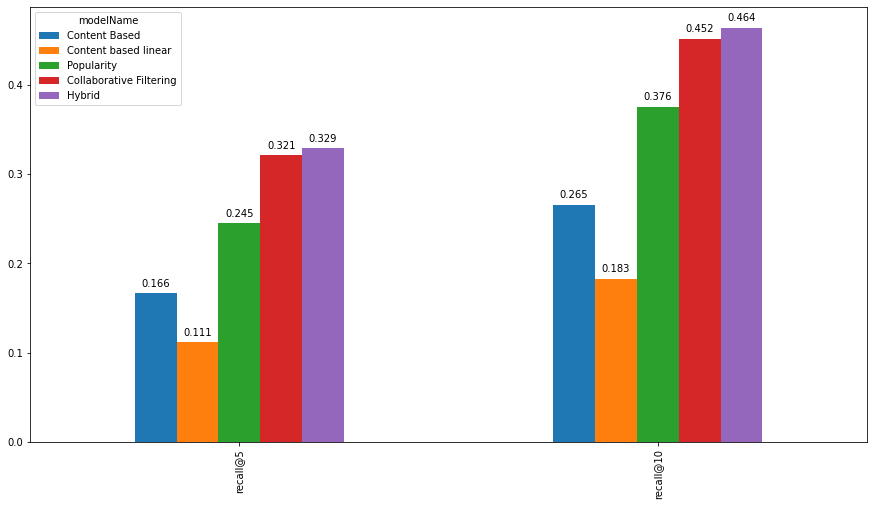

In [65]:
%matplotlib inline
ax = global_metrics_df.transpose().plot(kind='bar', figsize=(15,8))
for p in ax.patches:
    ax.annotate("%.3f" % p.get_height(), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 10), textcoords='offset points')

# Testing

In [56]:
def inspect_interactions(person_id, test_set=True):
    if test_set:
        interactions_df = interactions_test_indexed_df
    else:
        interactions_df = interactions_train_indexed_df
    return interactions_df.loc[person_id].merge(articles_df, 
                                                how='left', 
                                                left_on='contentId', 
                                                right_on='contentId').sort_values('eventStrength', 
                                                                                  ascending=False)[['eventStrength','contentId','title', 'url', 'lang']]

In [57]:
someone = -1479311724257856983
inspect_interactions(someone, test_set=False).head(20)

,eventStrength,contentId,title,url,lang
38,4.285402,7342707578347442862,"At eBay, Machine Learning is Driving Innovativ...",https://www.ebayinc.com/stories/news/at-ebay-m...,en
11,4.044394,-4460374799273064357,"Deep Learning for Chatbots, Part 1 - Introduction",http://www.wildml.com/2016/04/deep-learning-fo...,en
114,4.044394,-7959318068735027467,Auto-scaling scikit-learn with Spark,https://databricks.com/blog/2016/02/08/auto-sc...,en
64,3.807355,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
17,3.754888,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
76,3.700440,-398780385766545248,10 Stats About Artificial Intelligence That Wi...,http://www.fool.com/investing/2016/06/19/10-st...,en
78,3.643856,-4944551138301474550,Algorithms and architecture for job recommenda...,https://www.oreilly.com/ideas/algorithms-and-a...,en
29,3.584963,444378495316508239,How to choose algorithms for Microsoft Azure M...,https://azure.microsoft.com/en-us/documentatio...,en
115,3.584963,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
104,3.459432,-8085935119790093311,Graph Capabilities with the Elastic Stack,https://www.elastic.co/webinars/sneak-peek-of-...,en


In [58]:
hybrid_recommender_model.recommend_items(someone, topn=20, verbose=True)

,recStrengthHybrid,contentId,title,url,lang
0,35.497041,-6467708104873171151,5 reasons your employees aren't sharing their ...,http://justcuriousblog.com/2016/04/5-reasons-y...,en
1,34.012602,-8190931845319543363,Machine Learning Is At The Very Peak Of Its Hy...,https://arc.applause.com/2016/08/17/gartner-hy...,en
2,33.420035,2589533162305407436,6 reasons why I like KeystoneML,http://radar.oreilly.com/2015/07/6-reasons-why...,en
3,32.433850,4118743389464105405,Why Google App Engine rocks: A Google engineer...,https://cloudplatform.googleblog.com/2016/04/w...,en
4,32.403758,5237574390644778994,Meet Parsey's Cousins: Syntax for 40 languages...,https://research.googleblog.com/2016/08/meet-p...,en
5,32.047236,-9033211547111606164,Google's Cloud Machine Learning service is now...,https://techcrunch.com/2016/09/29/googles-clou...,en
6,31.886443,-7986975759046428357,It's The Future,https://circleci.com/blog/its-the-future/,en
7,31.728889,1005751836898964351,Seria Stranger Things uma obra de arte do algo...,https://www.linkedin.com/pulse/seria-stranger-...,pt
8,31.440437,5258604889412591249,Machine Learning Is No Longer Just for Experts,https://hbr.org/2016/10/machine-learning-is-no...,en
9,31.325952,-3269885695260066314,The Competitive Landscape for Machine Intellig...,https://hbr.org/2016/11/the-competitive-landsc...,en


# References
Original notebook: https://www.kaggle.com/gspmoreira/recommender-systems-in-python-101/notebook#Testing